In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

In [7]:
# Load train and test data
train_df = pd.read_csv("data/train_data.csv")
test_df = pd.read_csv("data/test_data.csv")

In [8]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

X_test = test_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_df['is_fraud']

# Standardize numerical columns
scaler_train = StandardScaler()
numeric_cols_train = X_train.select_dtypes(include=['number'])
X_train[numeric_cols_train.columns] = scaler_train.fit_transform(numeric_cols_train)

scaler_test = StandardScaler()
numeric_cols_test = X_test.select_dtypes(include=['number'])
X_test[numeric_cols_test.columns] = scaler_test.fit_transform(numeric_cols_test)

#### Random UnderSampling

In [9]:
# Apply random undersampling to train dataset
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f'Size of X_train after random undersampling: {len(X_train_rus)}')

Size of X_train after random undersampling: 80256


#### Smote-NC

In [10]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]

# Apply SMOTE-NC on training data
sm = SMOTENC(categorical_features=categorical_columns_idx, random_state=123, sampling_strategy=0.5)
X_train_smote, y_train_smote = sm.fit_resample(X_train_rus, y_train_rus)

print(f'Train data size:{len(X_train_smote)}')
print(f'Fraud proportion in train data: {round(y_train_smote.mean(), 2)}')

Train data size:109440
Fraud proportion in train data: 0.33


### One-Hot Encoding

In [11]:
# Apply one-hot encoding on train and test data
X_train_ohe = pd.get_dummies(X_train_smote, drop_first = True)
X_test_ohe = pd.get_dummies(X_test, drop_first = True)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

print(f'Number of columns after one-hot encoding: {len(X_train_ohe.columns)}')

Number of columns after one-hot encoding: 541


### Pipeline with Lasso

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Lasso Pipeline Results:
accuracy: 0.9977704678362573, precision: 0.9976141966759791, recall: 0.9973684210526316, f1: 0.9974911570524185
AUC: 1.0


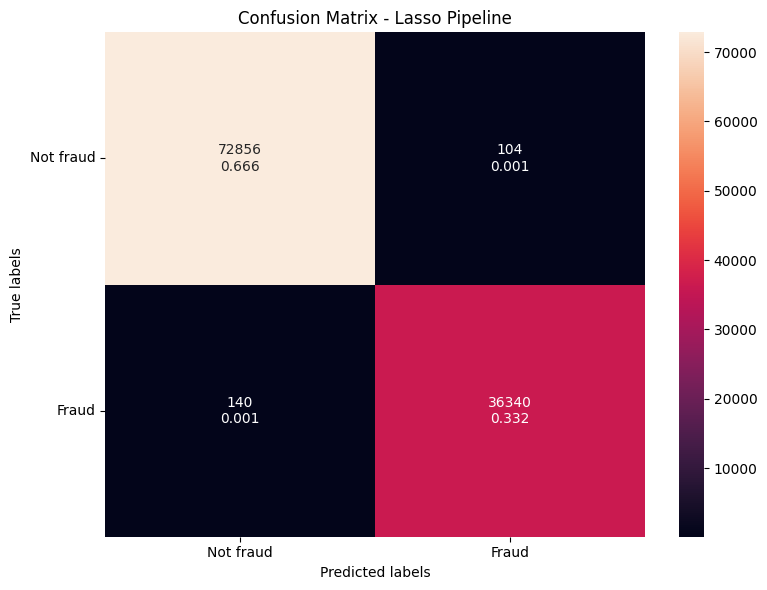

Chosen hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 150}

Top 10 most important features:
                     Feature  Importance
2           prev_trans_fraud    0.381784
7                visited_cat    0.283025
0                        amt    0.132076
4  merchant_prev_trans_fraud    0.095805
3          count_fraud_7days    0.038741
1                       hour    0.035300
6          hourly_risk_score    0.025735
5   merchant_acc_fraud_count    0.006326
8      first_second_purchase    0.001210


In [12]:

# Define the pipeline with Lasso for feature selection followed by RandomForest
lasso_pipe = Pipeline([
    ('feature_selection', SelectFromModel(Lasso(alpha=0.01))),
    ('classifier', RandomForestClassifier(random_state=123))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 150],
    'classifier__max_features': ['sqrt', 'log2', 20],
    'classifier__max_depth': [10, 15],
    'classifier__criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
cv_lasso_pipe = GridSearchCV(
    estimator=lasso_pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)

# Fit the grid search
cv_lasso_pipe.fit(X_train_ohe, y_train_smote)

# Get the best model
best_lasso_pipe = cv_lasso_pipe.best_estimator_

# Evaluate using cross-validation
sk_folds_lasso = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_lasso_pipe = cross_val_predict(best_lasso_pipe, X_train_ohe, y_train_smote, cv=sk_folds_lasso)

# Calculate metrics
auc_lasso_pipe = roc_auc_score(y_train_smote, y_pred_lasso_pipe)
print("\nLasso Pipeline Results:")
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_lasso_pipe)}, "
      f"precision: {precision_score(y_train_smote, y_pred_lasso_pipe, average='macro', zero_division=0.0)}, "
      f"recall: {recall_score(y_train_smote, y_pred_lasso_pipe, average='macro')}, "
      f"f1: {f1_score(y_train_smote, y_pred_lasso_pipe, average='macro', zero_division=0.0)}")
print(f'AUC: {round(auc_lasso_pipe, 2)}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_lasso = confusion_matrix(y_train_smote, y_pred_lasso_pipe)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_lasso.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_lasso.flatten()/np.sum(cm_lasso)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for Lasso Pipeline
ax = plt.subplot()
sns.heatmap(cm_lasso, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Lasso Pipeline')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()

# Report chosen hyperparameters
print(f'Chosen hyperparameters: {cv_lasso_pipe.best_params_}')

# Get feature importances from the best model
# First, identify which features were selected
selected_features_mask = best_lasso_pipe.named_steps['feature_selection'].get_support()
selected_features = X_train_ohe.columns[selected_features_mask]

# Get feature importances from the classifier
feature_importances = best_lasso_pipe.named_steps['classifier'].feature_importances_

# Create dataframe of importances
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

print('\nTop 10 most important features:')
print(importance_df.sort_values(by='Importance', ascending=False)[:10])

### Pipeline with RFECV

Fitting RFECV pipeline with GridSearchCV - this may take some time...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting estimator with 541 features.
Fitting estimator with 487 features.
Fitting estimator with 433 features.
Fitting estimator with 379 features.
Fitting estimator with 325 features.
Fitting estimator with 271 features.
Fitting estimator with 217 features.
Fitting estimator with 163 features.
Fitting estimator with 541 features.
Fitting estimator with 487 features.
Fitting estimator with 433 features.
Fitting estimator with 379 features.
Fitting estimator with 325 features.
Fitting estimator with 271 features.
Fitting estimator with 217 features.
Fitting estimator with 163 features.
Fitting estimator with 109 features.
Fitting estimator with 541 features.
Fitting estimator with 487 features.
Fitting estimator with 433 features.
Fitting estimator with 379 features.
Fitting estimator with 325 features.
Fitting estimator with 271 features.
Fitting estimator

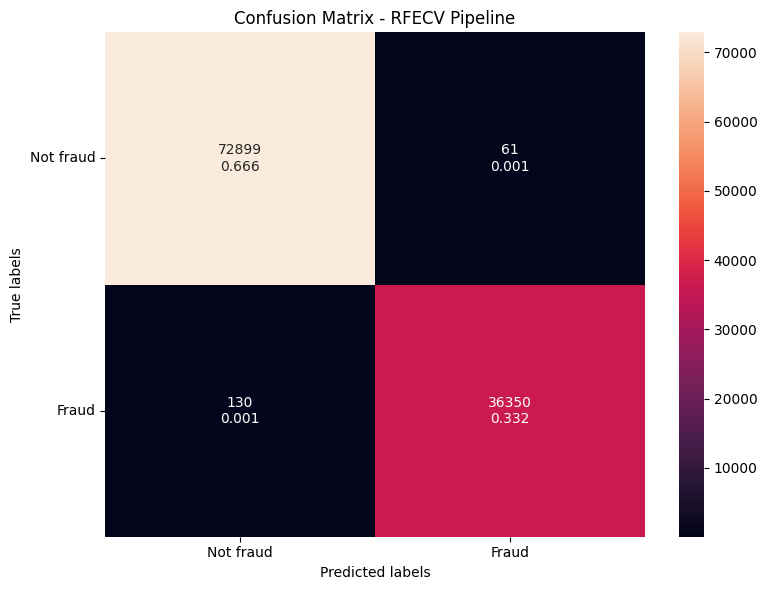

Chosen hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__max_features': 20, 'classifier__n_estimators': 150}

Optimal number of features selected by RFECV: 109
Selected features: ['zip', 'city_pop', 'amt', 'hour', 'year', 'age', 'prev_trans_fraud', 'count_fraud_7days', 'acc_fraud_count', 'merchant_prev_trans_fraud', 'merchant_count_fraud_past7days', 'merchant_acc_fraud_count', 'transaction_risk_score', 'hourly_risk_score', 'visited_cat', 'city_population_class', 'interval', 'first_second_purchase', 'interval_deviation', 'influential_merchant', 'gender_M', 'state_CA', 'state_FL', 'state_GA', 'state_IL', 'state_KS', 'state_MA', 'state_MD', 'state_MI', 'state_MN', 'state_NC', 'state_NJ', 'state_NY', 'state_OH', 'state_OK', 'state_PA', 'state_SD', 'state_TN', 'state_TX', 'state_VA', 'state_WI', 'job_Actor', 'job_Barista', 'job_Clothing/textile technologist', 'job_Copywriter', 'job_Designer', 'job_Electronics engineer', 'job_Engineer', 'job_Geologi

AttributeError: 'RFECV' object has no attribute 'grid_scores_'

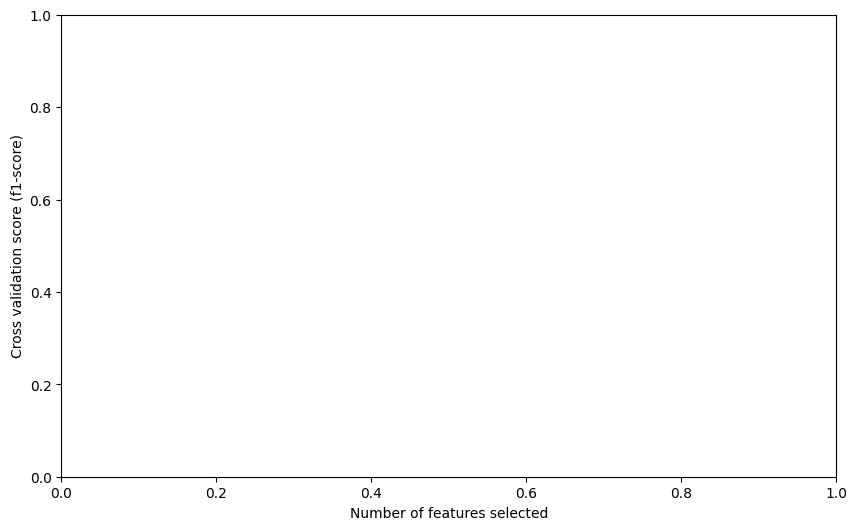

In [13]:

# Using a small RandomForest as the estimator for RFECV
rfecv_pipe = Pipeline([
    ('feature_selection', RFECV(
        estimator=RandomForestClassifier(n_estimators=100, random_state=123),
        step=0.1,  # Remove 10% of features at each iteration (a bit faster than 5 features since we have 524 columnns)
        cv=5,
        scoring='f1',
        min_features_to_select=5,
        n_jobs=-1,
        verbose=1
    )),
    ('classifier', RandomForestClassifier(random_state=123))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 150],
    'classifier__max_features': ['sqrt', 'log2', 20],
    'classifier__max_depth': [10, 15],
    'classifier__criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
cv_rfecv_pipe = GridSearchCV(
    estimator=rfecv_pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)

# Fit the grid search
print("Fitting RFECV pipeline with GridSearchCV - this may take some time...")
cv_rfecv_pipe.fit(X_train_ohe, y_train_smote)

# Get the best model
best_rfecv_pipe = cv_rfecv_pipe.best_estimator_

# Evaluate using cross-validation
sk_folds_rfecv = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_rfecv_pipe = cross_val_predict(best_rfecv_pipe, X_train_ohe, y_train_smote, cv=sk_folds_rfecv)

# Calculate metrics
auc_rfecv_pipe = roc_auc_score(y_train_smote, y_pred_rfecv_pipe)
print("\nRFECV Pipeline Results:")
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_rfecv_pipe)}, "
      f"precision: {precision_score(y_train_smote, y_pred_rfecv_pipe, average='macro', zero_division=0.0)}, "
      f"recall: {recall_score(y_train_smote, y_pred_rfecv_pipe, average='macro')}, "
      f"f1: {f1_score(y_train_smote, y_pred_rfecv_pipe, average='macro', zero_division=0.0)}")
print(f'AUC: {round(auc_rfecv_pipe, 2)}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_rfecv = confusion_matrix(y_train_smote, y_pred_rfecv_pipe)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_rfecv.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_rfecv.flatten()/np.sum(cm_rfecv)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for RFECV Pipeline
ax = plt.subplot()
sns.heatmap(cm_rfecv, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - RFECV Pipeline')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()

# Report chosen hyperparameters
print(f'Chosen hyperparameters: {cv_rfecv_pipe.best_params_}')

# Get number of selected features
n_features = best_rfecv_pipe.named_steps['feature_selection'].n_features_

# Get selected features
selected_features_mask = best_rfecv_pipe.named_steps['feature_selection'].get_support()
selected_features = X_train_ohe.columns[selected_features_mask]
print(f"\nOptimal number of features selected by RFECV: {n_features}")
print("Selected features:", selected_features.tolist())

# Get feature importances from the classifier
feature_importances = best_rfecv_pipe.named_steps['classifier'].feature_importances_

# Create dataframe of importances
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

print('\nTop 10 most important features:')
print(importance_df.sort_values(by='Importance', ascending=False)[:10])

# Plot the number of features and cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1-score)")
plt.plot(
    range(1, len(best_rfecv_pipe.named_steps['feature_selection'].grid_scores_) + 1),
    best_rfecv_pipe.named_steps['feature_selection'].grid_scores_
)
plt.title("RFECV Feature Selection Score")
plt.tight_layout()
plt.show()

**RFECV was computationally heavy** 

It took 6 hours to run and required a high ram, GPU computer. This is not optimal for for credit card detection where we need to catch fraud much quickly.
